# BrisT1D: Blood Glucose prediction

## Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from re import match

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/kaggle/train.csv")
test = pd.read_csv("/content/drive/MyDrive/kaggle/test.csv")

<ipython-input-3-55cf702248f9>:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/kaggle/train.csv")


In [4]:
test['bg-1:00'].isna().sum()

269

In [5]:
train.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


**Columns**

* **bg**: Blood Glucose
* **cals**: Calories Intake
* **insulin**: Insuline dosage
* **steps**: Steps walken
* **hr**: Mean heart rate
* **carbs**: Carbohydrates intake

In [6]:
# Get columns name for our features
col_bg = list(filter(lambda x: match(r"^bg*",x), train.columns))
col_insulin = list(filter(lambda x: match(r"^insulin*",x), train.columns))
col_hr = list(filter(lambda x: match(r"^hr*",x), train.columns))
col_cals = list(filter(lambda x: match(r"^cals*",x), train.columns))
col_carbs = list(filter(lambda x: match(r"^carbs*",x), train.columns))
col_steps = list(filter(lambda x: match(r"^steps*",x), train.columns))
col_activity = list(filter(lambda x: match(r"^activity*",x), train.columns))

## Time embedding

Time must be considered as a cycle, so 11pm is rightly considered as 2 hour before 1am, which would not be the case if we use a 0-1 scale.

A common mathematical translation of a cycle is to use the sinus and cosinus functions.

In [7]:
time_sin = {}
time_cos = {}
for i in range(0,1445, 5):
    time_sin[i] = np.sin(2 * np.pi * i / 1440)
    time_cos[i] = np.cos(2 * np.pi * i / 1440)

In [8]:
# Transform the time in minutes starting a midnight
train['time'] = pd.to_datetime(train['time'], format='%H:%M:%S')
test['time'] = pd.to_datetime(test['time'], format='%H:%M:%S')
train['time_min'] = train['time'].dt.hour * 60 + train['time'].dt.minute
test['time_min'] = test['time'].dt.hour * 60 + test['time'].dt.minute

In [9]:
def actual_time(row:str):
    if "indicator" in row['actual_time']:
        entry = row['actual_time'].split("_")[0]
        entry = entry.split("-")[1]
    else:
        entry = row['actual_time'].split("-")[1]
    minus = int(entry.split(":")[0]) * 60 + int(entry.split(":")[1])
    time = row['time_min'] - minus
    if time < 0:
        time += 1440
    return time

# Pre-Processing

Delete session for which there is no insulin

In [10]:
ids_no_insulin = [index for index, row in train.iterrows() if all(pd.isna(row[col]) for col in col_insulin)]

In [11]:
len(ids_no_insulin)

9365

In [12]:
train = train.drop(ids_no_insulin)
train = train.reset_index(drop=True)

In [13]:
train.shape

(167659, 509)

In [14]:
# Get a singular data frame for each feature
bg = train.loc[:,col_bg]
insulin = train.loc[:,col_insulin]
hr = train.loc[:,col_hr]
cals = train.loc[:,col_cals]
carbs = train.loc[:,col_carbs]
steps = train.loc[:,col_steps]

## Handle NAs

For the blood glucose, we expect continuous value across the 72 timesteps; we need to fill the NAs accordingly to the other columns.

In [14]:
def fill_na_values(dataframe, columns):
    filled_df = dataframe.copy()
    # For the remaining NA values, use the mean of adjacent non-NA values
    filled_df[columns] = filled_df[columns].interpolate(method='linear', axis = 1)
    # # Backward fill the first NA values
    filled_df[columns] = filled_df[columns].bfill(axis = 1)
    # Forward fill the last NA values
    filled_df[columns] = filled_df[columns].ffill(axis = 1)
    return filled_df

### **Blood Glucose**

#### **Train**

In [15]:
bg_filled = fill_na_values(train[col_bg], col_bg[0:-1])
print(bg_filled.shape)

print("After NAs filling")
print(bg_filled.head())

for col in bg_filled.columns:
  if col in train.columns:
    train[col] = bg_filled[col]

# Transform into long format
bg_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_bg, var_name='actual_time', value_name='bg')

# Normalize
scaler_bg = MinMaxScaler()
bg_normalized = scaler_bg.fit_transform(bg_long[['bg']])
bg_long['bg'] = bg_normalized
bg_long = bg_long.sort_values(['id','actual_time']).reset_index(drop=True)
bg_long.head()

# Extract target value
target_train = bg_long[bg_long['actual_time'] == 'bg+1:00']['bg']
target_train.head()

# Remove target from long dataframe
bg_X = bg_long[bg_long['actual_time'] != 'bg+1:00']

bg_X['actual_time_min'] = bg_X.apply(actual_time, axis=1)
bg_X = bg_X.drop(columns=['actual_time'])
bg_X = bg_X.sort_values(['id', 'actual_time_min']).reset_index(drop=True)


bg_X.head()

(167659, 73)
After NAs filling
   bg-5:55  bg-5:50  bg-5:45   bg-5:40   bg-5:35  bg-5:30   bg-5:25   bg-5:20  \
0      9.6      9.6      9.6  9.633333  9.666667      9.7  9.533333  9.366667   
1      9.7      9.7      9.7  9.533333  9.366667      9.2  9.033333  8.866667   
2      9.2      9.2      9.2  9.033333  8.866667      8.7  8.600000  8.500000   
3      8.7      8.7      8.7  8.600000  8.500000      8.4  8.300000  8.200000   
4      8.4      8.4      8.4  8.300000  8.200000      8.1  8.166667  8.233333   

   bg-5:15   bg-5:10  ...    bg-0:40    bg-0:35  bg-0:30    bg-0:25  \
0      9.2  9.033333  ...  17.433333  17.366667     17.3  16.933333   
1      8.7  8.600000  ...  16.933333  16.566667     16.2  15.833333   
2      8.4  8.300000  ...  15.833333  15.466667     15.1  14.866667   
3      8.1  8.166667  ...  14.866667  14.633333     14.4  14.233333   
4      8.3  8.733333  ...  14.233333  14.066667     13.9  13.866667   

     bg-0:20  bg-0:15    bg-0:10    bg-0:05  bg-0:00  b

<ipython-input-15-85a40cc2517d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_X['actual_time_min'] = bg_X.apply(actual_time, axis=1)


,id,p_num,time_min,bg,actual_time_min
0,p01_0,p01,370,0.289062,15
1,p01_0,p01,370,0.289062,20
2,p01_0,p01,370,0.289062,25
3,p01_0,p01,370,0.290365,30
4,p01_0,p01,370,0.291667,35


In [97]:
bg_filled.head()
bg_filled.head()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00,bg+1:00
0,9.6,9.6,9.6,9.633333,9.666667,9.7,9.533333,9.366667,9.2,9.033333,...,17.433333,17.366667,17.3,16.933333,16.566667,16.2,15.833333,15.466667,15.1,13.4
1,9.7,9.7,9.7,9.533333,9.366667,9.2,9.033333,8.866667,8.7,8.600000,...,16.933333,16.566667,16.2,15.833333,15.466667,15.1,14.866667,14.633333,14.4,12.8
2,9.2,9.2,9.2,9.033333,8.866667,8.7,8.600000,8.500000,8.4,8.300000,...,15.833333,15.466667,15.1,14.866667,14.633333,14.4,14.233333,14.066667,13.9,15.5
3,8.7,8.7,8.7,8.600000,8.500000,8.4,8.300000,8.200000,8.1,8.166667,...,14.866667,14.633333,14.4,14.233333,14.066667,13.9,13.866667,13.833333,13.8,14.8
4,8.4,8.4,8.4,8.300000,8.200000,8.1,8.166667,8.233333,8.3,8.733333,...,14.233333,14.066667,13.9,13.866667,13.833333,13.8,13.666667,13.533333,13.4,12.7


In [19]:
for col in bg_filled.columns:
  if col in train.columns:
    train[col] = bg_filled[col]

Transform in long format

In [20]:
bg_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_bg, var_name='actual_time', value_name='bg')

In [21]:
scaler_bg = MinMaxScaler()
bg_normalized = scaler_bg.fit_transform(bg_long[['bg']])
bg_long['bg'] = bg_normalized
bg_long = bg_long.sort_values(['id','actual_time']).reset_index(drop=True)
bg_long.head()

,id,p_num,time_min,actual_time,bg
0,p01_0,p01,370,bg+1:00,0.437500
1,p01_0,p01,370,bg-0:00,0.503906
2,p01_0,p01,370,bg-0:05,0.518229
3,p01_0,p01,370,bg-0:10,0.532552
4,p01_0,p01,370,bg-0:15,0.546875


In [27]:
target_train = bg_long[bg_long['actual_time'] == 'bg+1:00']['bg']
target_train.head()

# Remove target from long dataframe
bg_X = bg_long[bg_long['actual_time'] != 'bg+1:00']

In [29]:
bg_X['actual_time_min'] = bg_X.apply(actual_time, axis=1)
bg_X = bg_X.drop(columns=['actual_time'])
bg_X = bg_X.sort_values(['id', 'actual_time_min']).reset_index(drop=True)

<ipython-input-29-e45bc98b3f7d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_X['actual_time_min'] = bg_X.apply(actual_time, axis=1)


In [30]:
bg_X.head()

,id,p_num,time_min,bg,actual_time_min
0,p01_0,p01,370,0.289062,15
1,p01_0,p01,370,0.289062,20
2,p01_0,p01,370,0.289062,25
3,p01_0,p01,370,0.290365,30
4,p01_0,p01,370,0.291667,35


#### **Test**

In [31]:
# Get a singular data frame for each feature
bg_t = test.loc[:,col_bg[0:-1]]
insulin_t = test.loc[:,col_insulin]
hr_t = test.loc[:,col_hr]
cals_t = test.loc[:,col_cals]
carbs_t = test.loc[:,col_carbs]
steps_t = test.loc[:,col_steps]

In [32]:
bg_t.head()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00
0,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,NaN,NaN,...,NaN,NaN,10.5,NaN,NaN,NaN,9.4,NaN,NaN,9.6
1,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,9.1,NaN,...,4.5,NaN,NaN,6.4,NaN,NaN,6.3,NaN,NaN,4.6
2,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,NaN,NaN,...,6.6,NaN,NaN,8.1,NaN,NaN,8.3,NaN,NaN,8.0
3,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,NaN,NaN,...,7.5,NaN,NaN,7.8,NaN,NaN,8.5,NaN,NaN,9.9
4,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,12.2,NaN,...,3.4,NaN,NaN,3.2,NaN,NaN,3.7,NaN,NaN,5.3


Handle NAs

In [33]:
bg_t_filled = fill_na_values(bg_t, col_bg[0:-1])
print(bg_t_filled.shape)
bg_t_filled.head()

(3644, 72)


,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00
0,9.2,9.2,9.533333,9.866667,10.200000,10.233333,10.266667,10.300000,10.266667,10.233333,...,11.766667,11.133333,10.500000,10.225,9.950000,9.675000,9.4,9.466667,9.533333,9.6
1,9.9,9.9,9.900000,9.733333,9.566667,9.400000,9.300000,9.200000,9.100000,8.833333,...,4.500000,5.133333,5.766667,6.400,6.366667,6.333333,6.3,5.733333,5.166667,4.6
2,5.5,5.5,5.500000,5.500000,5.500000,5.400000,5.300000,5.200000,5.200000,5.200000,...,6.600000,7.100000,7.600000,8.100,8.166667,8.233333,8.3,8.200000,8.100000,8.0
3,3.4,3.4,3.566667,3.733333,3.900000,4.166667,4.433333,4.700000,4.500000,4.300000,...,7.500000,7.600000,7.700000,7.800,8.033333,8.266667,8.5,8.966667,9.433333,9.9
4,8.3,8.3,8.300000,8.866667,9.433333,10.000000,10.733333,11.466667,12.200000,12.400000,...,3.400000,3.333333,3.266667,3.200,3.366667,3.533333,3.7,4.233333,4.766667,5.3


In [35]:
for col in bg_t_filled.columns:
  if col in test.columns:
    test[col] = bg_t_filled[col]

test[col_bg[0:-1]].head()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,bg-0:45,bg-0:40,bg-0:35,bg-0:30,bg-0:25,bg-0:20,bg-0:15,bg-0:10,bg-0:05,bg-0:00
0,9.2,9.2,9.533333,9.866667,10.200000,10.233333,10.266667,10.300000,10.266667,10.233333,...,11.766667,11.133333,10.500000,10.225,9.950000,9.675000,9.4,9.466667,9.533333,9.6
1,9.9,9.9,9.900000,9.733333,9.566667,9.400000,9.300000,9.200000,9.100000,8.833333,...,4.500000,5.133333,5.766667,6.400,6.366667,6.333333,6.3,5.733333,5.166667,4.6
2,5.5,5.5,5.500000,5.500000,5.500000,5.400000,5.300000,5.200000,5.200000,5.200000,...,6.600000,7.100000,7.600000,8.100,8.166667,8.233333,8.3,8.200000,8.100000,8.0
3,3.4,3.4,3.566667,3.733333,3.900000,4.166667,4.433333,4.700000,4.500000,4.300000,...,7.500000,7.600000,7.700000,7.800,8.033333,8.266667,8.5,8.966667,9.433333,9.9
4,8.3,8.3,8.300000,8.866667,9.433333,10.000000,10.733333,11.466667,12.200000,12.400000,...,3.400000,3.333333,3.266667,3.200,3.366667,3.533333,3.7,4.233333,4.766667,5.3


Turn into long format dataframe

In [39]:
bg_t_long = pd.melt(test, id_vars=['id', 'p_num', 'time_min'], value_vars=col_bg[0:-1], var_name='actual_time', value_name='bg')

bg_t_normalized = scaler_bg.transform(bg_t_long[['bg']])
bg_t_long['bg'] = bg_t_normalized
bg_t_long = bg_t_long.sort_values(['id','actual_time']).reset_index(drop=True)
bg_t_long.head()

,id,p_num,time_min,actual_time,bg
0,p01_8459,p01,405,bg-0:00,0.289062
1,p01_8459,p01,405,bg-0:05,0.286458
2,p01_8459,p01,405,bg-0:10,0.283854
3,p01_8459,p01,405,bg-0:15,0.281250
4,p01_8459,p01,405,bg-0:20,0.291992


Get time features

In [40]:
bg_t_long['actual_time_min'] = bg_t_long.apply(actual_time, axis=1)
bg_t_long = bg_t_long.drop(columns=['actual_time'])
bg_t_long = bg_t_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)

bg_t_long.head()

,id,p_num,time_min,bg,actual_time_min
0,p01_8459,p01,405,0.273438,50
1,p01_8459,p01,405,0.273438,55
2,p01_8459,p01,405,0.286458,60
3,p01_8459,p01,405,0.299479,65
4,p01_8459,p01,405,0.312500,70


### **Steps**

#### **Train**

In [49]:
steps_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_steps, var_name='actual_time', value_name='steps')
steps_long['actual_time_min'] = steps_long.apply(actual_time, axis=1)
steps_long = steps_long.drop(columns=['actual_time'])

In [50]:
scaler_steps = MinMaxScaler()
steps_long["steps"] = scaler_steps.fit_transform(steps_long[['steps']])
steps_long.head()

,id,p_num,time_min,steps,actual_time_min
0,p01_0,p01,370,NaN,15
1,p01_1,p01,385,NaN,30
2,p01_2,p01,400,NaN,45
3,p01_3,p01,415,NaN,60
4,p01_4,p01,430,NaN,75


In [51]:
steps_long["steps_indicator"] = steps_long["steps"].notna().astype(int)

steps_long = steps_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
steps_long['steps'] = steps_long['steps'].fillna(-0.01)
steps_long.head()

,id,p_num,time_min,steps,actual_time_min,steps_indicator
0,p01_0,p01,370,-0.01,15,0
1,p01_0,p01,370,-0.01,20,0
2,p01_0,p01,370,-0.01,25,0
3,p01_0,p01,370,-0.01,30,0
4,p01_0,p01,370,-0.01,35,0


#### **Test**

In [52]:
steps_t_long = pd.melt(test, id_vars=['id', 'p_num', 'time_min'], value_vars=col_steps, var_name='actual_time', value_name='steps')
steps_t_long['actual_time_min'] = steps_t_long.apply(actual_time, axis=1)
steps_t_long = steps_t_long.drop(columns=['actual_time'])

In [53]:
steps_t_long["steps"] = scaler_steps.transform(steps_t_long[['steps']])
steps_t_long.head()

,id,p_num,time_min,steps,actual_time_min
0,p01_8459,p01,405,0.000000,50
1,p01_8460,p01,685,NaN,330
2,p01_8461,p01,885,NaN,530
3,p01_8462,p01,270,0.000000,1355
4,p01_8463,p01,260,0.020603,1345


In [54]:
steps_t_long["steps_indicator"] = steps_t_long["steps"].notna().astype(int)

steps_t_long = steps_t_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
steps_t_long['steps'] = steps_t_long['steps'].fillna(-0.01)
steps_t_long.head()

,id,p_num,time_min,steps,actual_time_min,steps_indicator
0,p01_8459,p01,405,0.00,50,1
1,p01_8459,p01,405,-0.01,55,0
2,p01_8459,p01,405,0.00,60,1
3,p01_8459,p01,405,0.00,65,1
4,p01_8459,p01,405,0.00,70,1


### **Insulin**

#### **Train**

In [55]:
insulin_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_insulin, var_name='actual_time', value_name='insulin')
insulin_long['actual_time_min'] = insulin_long.apply(actual_time, axis=1)
insulin_long = insulin_long.drop(columns=['actual_time'])

scaler_insulin = MinMaxScaler()
insulin_long["insulin"] = scaler_insulin.fit_transform(insulin_long[['insulin']])

insulin_long["insulin_indicator"] = insulin_long["insulin"].notna().astype(int)

insulin_long = insulin_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
insulin_long['insulin'] = insulin_long['insulin'].fillna(-0.01)
insulin_long.head()

,id,p_num,time_min,insulin,actual_time_min,insulin_indicator
0,p01_0,p01,370,0.006781,15,1
1,p01_0,p01,370,0.006781,20,1
2,p01_0,p01,370,0.006781,25,1
3,p01_0,p01,370,0.006781,30,1
4,p01_0,p01,370,0.006781,35,1


#### **Test**

In [57]:
insulin_t_long = pd.melt(test, id_vars=['id', 'p_num', 'time_min'], value_vars=col_insulin, var_name='actual_time', value_name='insulin')
insulin_t_long['actual_time_min'] = insulin_t_long.apply(actual_time, axis=1)
insulin_t_long = insulin_t_long.drop(columns=['actual_time'])

insulin_t_long["insulin"] = scaler_insulin.transform(insulin_t_long[['insulin']])

insulin_t_long["insulin_indicator"] = insulin_t_long["insulin"].notna().astype(int)

insulin_t_long = insulin_t_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
insulin_t_long['insulin'] = insulin_t_long['insulin'].fillna(-0.01)
insulin_t_long.head()

,id,p_num,time_min,insulin,actual_time_min,insulin_indicator
0,p01_8459,p01,405,0.006781,50,1
1,p01_8459,p01,405,0.006781,55,1
2,p01_8459,p01,405,0.006781,60,1
3,p01_8459,p01,405,0.006781,65,1
4,p01_8459,p01,405,0.006781,70,1


### Carbs

#### **Train**

In [58]:
carbs_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_carbs, var_name='actual_time', value_name='carbs')
carbs_long['actual_time_min'] = carbs_long.apply(actual_time, axis=1)
carbs_long = carbs_long.drop(columns=['actual_time'])

scaler_carbs = MinMaxScaler()
carbs_long["carbs"] = scaler_carbs.fit_transform(carbs_long[['carbs']])

carbs_long["carbs_indicator"] = carbs_long["carbs"].notna().astype(int)

carbs_long = carbs_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
carbs_long['carbs'] = carbs_long['carbs'].fillna(-0.01)
carbs_long.head()

,id,p_num,time_min,carbs,actual_time_min,carbs_indicator
0,p01_0,p01,370,-0.01,15,0
1,p01_0,p01,370,-0.01,20,0
2,p01_0,p01,370,-0.01,25,0
3,p01_0,p01,370,-0.01,30,0
4,p01_0,p01,370,-0.01,35,0


#### **Test**

In [59]:
carbs_t_long = pd.melt(test, id_vars=['id', 'p_num', 'time_min'], value_vars=col_carbs, var_name='actual_time', value_name='carbs')
carbs_t_long['actual_time_min'] = carbs_t_long.apply(actual_time, axis=1)
carbs_t_long = carbs_t_long.drop(columns=['actual_time'])

carbs_t_long["carbs"] = scaler_carbs.transform(carbs_t_long[['carbs']])

carbs_t_long["carbs_indicator"] = carbs_t_long["carbs"].notna().astype(int)

carbs_t_long = carbs_t_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
carbs_t_long['carbs'] = carbs_t_long['carbs'].fillna(-0.01)
carbs_t_long.head()

,id,p_num,time_min,carbs,actual_time_min,carbs_indicator
0,p01_8459,p01,405,-0.01,50,0
1,p01_8459,p01,405,-0.01,55,0
2,p01_8459,p01,405,-0.01,60,0
3,p01_8459,p01,405,-0.01,65,0
4,p01_8459,p01,405,-0.01,70,0


### Cals

#### **Train**

In [63]:
cals_long = pd.melt(train, id_vars=['id', 'p_num', 'time_min'], value_vars=col_cals, var_name='actual_time', value_name='cals')
cals_long['actual_time_min'] = cals_long.apply(actual_time, axis=1)
cals_long = cals_long.drop(columns=['actual_time'])

scaler_cals = MinMaxScaler()
cals_long["cals"] = scaler_cals.fit_transform(cals_long[['cals']])

cals_long["cals_indicator"] = cals_long["cals"].notna().astype(int)

cals_long = cals_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
cals_long['cals'] = cals_long['cals'].fillna(-0.01)
cals_long.head()

,id,p_num,time_min,cals,actual_time_min,cals_indicator
0,p01_0,p01,370,-0.01,15,0
1,p01_0,p01,370,-0.01,20,0
2,p01_0,p01,370,-0.01,25,0
3,p01_0,p01,370,-0.01,30,0
4,p01_0,p01,370,-0.01,35,0


#### **Test**

In [64]:
cals_t_long = pd.melt(test, id_vars=['id', 'p_num', 'time_min'], value_vars=col_cals, var_name='actual_time', value_name='cals')
cals_t_long['actual_time_min'] = cals_t_long.apply(actual_time, axis=1)
cals_t_long = cals_t_long.drop(columns=['actual_time'])

cals_t_long["cals"] = scaler_cals.transform(cals_t_long[['cals']])

cals_t_long["cals_indicator"] = cals_t_long["cals"].notna().astype(int)

cals_t_long = cals_t_long.sort_values(['id', 'actual_time_min']).reset_index(drop=True)
cals_t_long['cals'] = cals_t_long['cals'].fillna(-0.01)
cals_t_long.head()

,id,p_num,time_min,cals,actual_time_min,cals_indicator
0,p01_8459,p01,405,0.045404,50,1
1,p01_8459,p01,405,0.045404,55,1
2,p01_8459,p01,405,0.042819,60,1
3,p01_8459,p01,405,0.044542,65,1
4,p01_8459,p01,405,0.053588,70,1


## Create input

#### **Train**

We will not use heart rate and activity

In [65]:
# Add time value as two cyclic features
bg_X['time_cos'] = bg_X['actual_time_min'].map(time_cos)
bg_X['time_sin'] = bg_X['actual_time_min'].map(time_sin)

bg_X.head()

,id,p_num,time_min,bg,actual_time_min,time_cos,time_sin
0,p01_0,p01,370,0.289062,15,0.997859,0.065403
1,p01_0,p01,370,0.289062,20,0.996195,0.087156
2,p01_0,p01,370,0.289062,25,0.994056,0.108867
3,p01_0,p01,370,0.290365,30,0.991445,0.130526
4,p01_0,p01,370,0.291667,35,0.988362,0.152123


In [66]:
# Merge the dataframes
merged_df = pd.merge(bg_X, insulin_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df = pd.merge(merged_df, carbs_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df = pd.merge(merged_df, cals_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df = pd.merge(merged_df, steps_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')


merged_df.head()

,id,p_num,time_min,bg,actual_time_min,time_cos,time_sin,insulin,insulin_indicator,carbs,carbs_indicator,cals,cals_indicator,steps,steps_indicator
0,p01_0,p01,370,0.289062,15,0.997859,0.065403,0.006781,1,-0.01,0,-0.01,0,-0.01,0
1,p01_0,p01,370,0.289062,20,0.996195,0.087156,0.006781,1,-0.01,0,-0.01,0,-0.01,0
2,p01_0,p01,370,0.289062,25,0.994056,0.108867,0.006781,1,-0.01,0,-0.01,0,-0.01,0
3,p01_0,p01,370,0.290365,30,0.991445,0.130526,0.006781,1,-0.01,0,-0.01,0,-0.01,0
4,p01_0,p01,370,0.291667,35,0.988362,0.152123,0.006781,1,-0.01,0,-0.01,0,-0.01,0


In [67]:
merged_df.isna().sum()

,0
id,0
p_num,0
time_min,0
bg,0
actual_time_min,0
time_cos,0
time_sin,0
insulin,0
insulin_indicator,0
carbs,0


In [69]:
X = merged_df.drop(columns = ["id", "p_num", "time_min", "actual_time_min"])

X = X.values
X = X.reshape((-1, 72, X.shape[1]))

X.shape

(167659, 72, 11)

#### **Test**

In [72]:
bg_t_long['time_cos'] = bg_t_long['actual_time_min'].map(time_cos)
bg_t_long['time_sin'] = bg_t_long['actual_time_min'].map(time_sin)

bg_t_long.head()

,id,p_num,time_min,bg,actual_time_min,time_cos,time_sin
0,p01_8459,p01,405,0.273438,50,0.976296,0.216440
1,p01_8459,p01,405,0.273438,55,0.971342,0.237686
2,p01_8459,p01,405,0.286458,60,0.965926,0.258819
3,p01_8459,p01,405,0.299479,65,0.960050,0.279829
4,p01_8459,p01,405,0.312500,70,0.953717,0.300706


In [73]:
# Merge the dataframes
merged_df_test = pd.merge(bg_t_long, insulin_t_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df_test = pd.merge(merged_df_test, carbs_t_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df_test = pd.merge(merged_df_test, cals_t_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')
merged_df_test = pd.merge(merged_df_test, steps_t_long, on=['id', 'p_num', 'time_min', 'actual_time_min'], how='left')


merged_df_test.head()

,id,p_num,time_min,bg,actual_time_min,time_cos,time_sin,insulin,insulin_indicator,carbs,carbs_indicator,cals,cals_indicator,steps,steps_indicator
0,p01_8459,p01,405,0.273438,50,0.976296,0.216440,0.006781,1,-0.01,0,0.045404,1,0.00,1
1,p01_8459,p01,405,0.273438,55,0.971342,0.237686,0.006781,1,-0.01,0,0.045404,1,-0.01,0
2,p01_8459,p01,405,0.286458,60,0.965926,0.258819,0.006781,1,-0.01,0,0.042819,1,0.00,1
3,p01_8459,p01,405,0.299479,65,0.960050,0.279829,0.006781,1,-0.01,0,0.044542,1,0.00,1
4,p01_8459,p01,405,0.312500,70,0.953717,0.300706,0.006781,1,-0.01,0,0.053588,1,0.00,1


In [75]:
merged_df_test.isna().sum()

,0
id,0
p_num,0
time_min,0
bg,0
actual_time_min,0
time_cos,0
time_sin,0
insulin,0
insulin_indicator,0
carbs,0


In [74]:
X_test = merged_df_test.drop(columns = ["id", "p_num", "time_min", "actual_time_min"])

X_test = X_test.values
X_test = X_test.reshape((-1, 72, X_test.shape[1]))

X_test.shape

(3644, 72, 11)

### Save Set

In [85]:
merged_df_test.to_csv('/content/drive/MyDrive/kaggle/processed_test.csv', index=False)
merged_df.to_csv('/content/drive/MyDrive/kaggle/processed_train.csv', index=False)

In [16]:
merged_df_test = pd.read_csv('/content/drive/MyDrive/kaggle/processed_test.csv')
merged_df = pd.read_csv('/content/drive/MyDrive/kaggle/processed_train.csv')

In [17]:
X_test = merged_df_test.drop(columns = ["id", "p_num", "time_min", "actual_time_min"])

X_test = X_test.values
X_test = X_test.reshape((-1, 72, X_test.shape[1]))

X_test.shape

(3644, 72, 11)

In [18]:
X = merged_df.drop(columns = ["id", "p_num", "time_min", "actual_time_min"])

X = X.values
X = X.reshape((-1, 72, X.shape[1]))

X.shape

(167659, 72, 11)

### **simple LSTM**

In [19]:
def lstm():
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics =  ['mae'])

    return model

In [20]:
model = lstm()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model = lstm()
history = model.fit(X, target_train, epochs=20, batch_size=128, validation_split=0.2, verbose=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0177 - mae: 0.0989 - val_loss: 0.0073 - val_mae: 0.0661
Epoch 2/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0101 - mae: 0.0761 - val_loss: 0.0067 - val_mae: 0.0620
Epoch 3/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0087 - mae: 0.0705 - val_loss: 0.0061 - val_mae: 0.0586
Epoch 4/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0078 - mae: 0.0673 - val_loss: 0.0058 - val_mae: 0.0571
Epoch 5/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0073 - mae: 0.0647 - val_loss: 0.0059 - val_mae: 0.0572
Epoch 6/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0070 - mae: 0.0632 - val_loss: 0.0060 - val_mae: 0.0574
Epoch 7/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0068 - mae: 0.0622 - val_loss: 0.0056 - val_mae: 0.0563
Epoch 8/20
1048/1048 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0067 - mae: 0.0618 - val_loss: 0.0052 - val_mae: 0.0540
Epoch 9/20
1048/1048 ━━━━━━━━━━━━━━━━━━━

In [23]:
model.save("/content/drive/MyDrive/kaggle/model_lstm.keras")

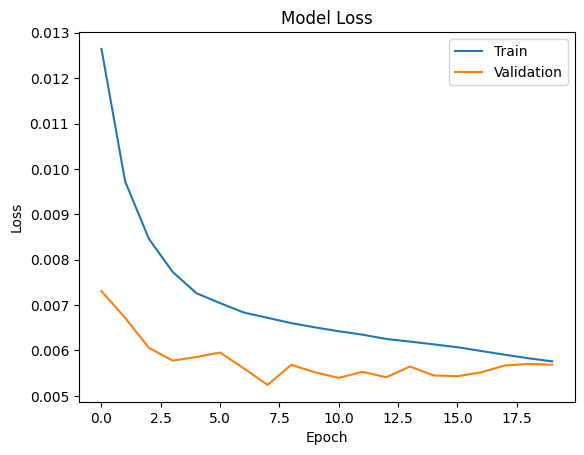

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

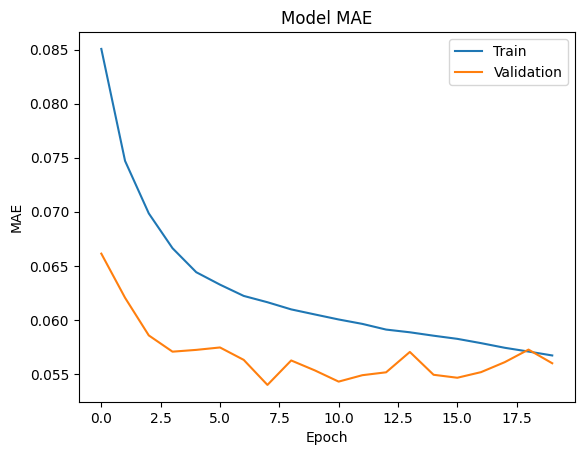

In [25]:
# prompt: plot mae curve of history

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [76]:
y_train.to_csv('/content/drive/MyDrive/kaggle/y_train.csv', index=False)

NameError: name 'y_train' is not defined

#### Predict

In [26]:
y_pred = model.predict(X_test)

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [29]:
y_pred_inverse = scaler_bg.inverse_transform(y_pred)
y_pred_inverse

array([[7.5148773],
       [4.7828345],
       [6.8737764],
       ...,
       [8.025942 ],
       [7.098977 ],
       [7.5465364]], dtype=float32)

In [37]:
id = test.sort_values(by=['id', 'time_min'])['id'].values

In [40]:
Y_test = pd.DataFrame({"id": id, "bg+1:00": y_pred_inverse.flatten()})

In [41]:
Y_test.to_csv('/content/drive/MyDrive/kaggle/submission.csv', index=False)

In [46]:
X.shape

(167659, 72, 11)

### **CNN-LSTM**

In [74]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten


def build_cnn_lstm_model(input_shape):
    model = Sequential()

    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100, return_sequences=False))

    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Example usage



In [75]:
input_shape = X.shape  # Adjust according to your data
model_cnn_lstm = build_cnn_lstm_model(input_shape)

model_cnn_lstm.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_52                  │ (None, 167659, 70, 32)      │           1,088 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_53                  │ (None, 167659, 68, 64)      │           6,208 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_54                  │ (None, 167659, 34, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_55                  │ (None, 167659, 32, 128)     │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_56                  │ (None, 167659, 16, 128)     │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_57                  │ (None, 167659, 2048)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100)                 │         859,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 891,701 (3.40 MB)

 Trainable params: 891,701 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model_cnn_lstm = build_cnn_lstm_model(X.shape[1:3])
history_cnn = model_cnn_lstm.fit(X, target_train, epochs=20, batch_size=128, validation_split=0.2, verbose=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Kernel shape must have the same length as input, but received kernel of shape (3, 11, 32) and input of shape (None, 11).